# 📊 Entrenamiento y Validación de Modelos

En esta fase se desarrolla el núcleo del proyecto de detección de imágenes médicas manipuladas. Aquí se construyen, entrenan y evalúan múltiples modelos de machine learning para abordar el problema como una clasificación binaria. La tarea consiste en identificar si una imagen médica ha sido manipulada o no, utilizando las características extraídas previamente.

Se implementan técnicas para dividir el dataset en conjuntos de **entrenamiento, validación y prueba**, lo que permite evaluar el rendimiento de los modelos y evitar problemas como el overfitting. Además, se utilizan métricas de clasificación y visualizaciones para analizar los resultados.

---

## 🧠 Modelos implementados / Models implemented
Se probaron diferentes algoritmos para comparar su rendimiento:

- ✅ **Logistic Regression**
- ✅ **K-Nearest Neighbors (KNN)**
- ✅ **Random Forest**
- ✅ **Support Vector Machines (SVM)**
- ✅ **Multilayer Neural Network**

Cada modelo fue entrenado con los datos seleccionados en la fase anterior y evaluado usando técnicas de validación cruzada y partición estratificada de datos.

---

## 📦 Output esperado / Expected Output

- ✅ Reportes de desempeño de cada modelo (métricas como precisión, recall, F1-score, AUC-ROC).

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut, GroupKFold, GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim


In [22]:
# Cargar el archivo
data = np.load("data.npz")

# Acceder a los arrays
X = data['X']
y = data['y']
groups = data['groups']

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"Shape groups: {groups.shape}")

Shape X: (790, 30)
Shape y: (790,)
Shape groups: (790,)


# Split forma 1

In [21]:
# Supongamos que tienes:
# X: tus features
# y: tus labels
# groups: el array de uuid por cada muestra (debe tener misma longitud que X)

# 🔹 Primer split: 90% Train+Val, 10% Test
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y[train_val_idx], y[test_idx]
groups_train_val = groups[train_val_idx]

# 🔹 Segundo split: 90% Train, 10% Validación dentro del 90% que quedó
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss_inner.split(X_train_val, y_train_val, groups=groups_train_val))

X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
groups_train = groups_train_val[train_idx]
groups_val = groups_train_val[val_idx]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (600, 30), Val: (115, 30), Test: (75, 30)


# Split forma 2

In [24]:
# Conteo de clases
unique, counts = np.unique(y_train, return_counts=True)
print("Conteo de clases en y_train:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_val, return_counts=True)
print("Conteo de clases en y_val:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_test, return_counts=True)
print("Conteo de clases en y_test:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

Conteo de clases en y_train:
Clase 0: 165 muestras
Clase 1: 435 muestras
Conteo de clases en y_val:
Clase 0: 50 muestras
Clase 1: 65 muestras
Conteo de clases en y_test:
Clase 0: 10 muestras
Clase 1: 65 muestras


# Logistic Regression

In [25]:
# GroupKFold
gkf = GroupKFold(n_splits=5)


# Escalar manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)



# Modelo base
lr = LogisticRegression(max_iter=1000)

# Definir grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],             # Regularización
    'solver': ['lbfgs', 'liblinear'],         # Algoritmos
    'penalty': ['l2']                         # Tipo de penalización (solo 'l2' es compatible con lbfgs y liblinear)
}

# Métricas para evaluar
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=gkf,
                    scoring=scoring, refit='f1', return_train_score=False)

# Entrenar
grid.fit(X_scaled, y_train, groups=groups_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.best_score_:.4f}")

# Puedes imprimir más métricas si deseas:
means = grid.cv_results_
print(f"✅ Accuracy medio: {means['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:   {means['mean_test_recall'][grid.best_index_]:.4f}")

🔍 Mejor combinación de hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
📈 Mejor F1-score (CV): 0.8341
✅ Accuracy medio: 0.7200
✅ Recall medio:   0.9933


In [38]:

# 2. Escalado y selección de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Modelo con ajuste fino
lr = LogisticRegression(
    C=0.1,                   # Mayor regularización
    penalty='l2',
    solver='liblinear',
    max_iter=1000,           # Más iteraciones para convergencia
    random_state=42
)

# 5. Entrenamiento y evaluación
lr.fit(X_train_scaled, y_train)

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, lr.predict(X_train_scaled), target_names=["Real", "Fake"], zero_division=0.0))

print("\n🔹 Evaluación en VALIDACIÓN:")
y_pred_val = lr.predict(X_val_scaled)
print(classification_report(y_val, y_pred_val, target_names=["Real", "Fake"], zero_division=0.0))

🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

        Real       0.77      0.06      0.11       165
        Fake       0.74      0.99      0.85       435

    accuracy                           0.74       600
   macro avg       0.75      0.53      0.48       600
weighted avg       0.75      0.74      0.64       600


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        50
        Fake       0.57      1.00      0.72        65

    accuracy                           0.57       115
   macro avg       0.28      0.50      0.36       115
weighted avg       0.32      0.57      0.41       115



# Knn Neighbors

In [27]:
# Leave-One-Out
loo = LeaveOneOut()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Modelo base
knn = KNeighborsClassifier()

# Grilla de hiperparámetros
param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# Scoring múltiple
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearch con LOO
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # el mejor se elige por f1
    cv=loo,
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid.fit(X_scaled, y_train)

best_params = grid.best_params_


# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")

Fitting 600 folds for each of 6 candidates, totalling 3600 fits
🔍 Mejor combinación de hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
📈 Mejor F1-score (CV): 0.7017
✅ Accuracy medio:       0.9300
✅ Recall medio:         0.7017


In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)
knn.fit(X_scaled, y_train)

# 5. Evaluación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, knn.predict(X_scaled)))

print("\n🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, knn.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       165
           1       0.96      0.98      0.97       435

    accuracy                           0.96       600
   macro avg       0.96      0.94      0.95       600
weighted avg       0.96      0.96      0.96       600


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.67      0.24      0.35        50
           1       0.61      0.91      0.73        65

    accuracy                           0.62       115
   macro avg       0.64      0.57      0.54       115
weighted avg       0.63      0.62      0.57       115



# Random Forest

In [30]:
# GroupKFold
gkf = GroupKFold(n_splits=5)


# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Definir modelo base
rf = RandomForestClassifier(random_state=42)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# Crear GridSearchCV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,  # también puedes usar 'recall' si priorizas eso
    cv=gkf,
    refit='f1',  # el mejor se elige por f1
    n_jobs=-1,
    verbose=1
)


# Ejecutar búsqueda
grid.fit(X_scaled, y_train, groups=groups_train)
best_params = grid.best_params_

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Mejor combinación de hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
📈 Mejor F1-score (CV): 0.7947
✅ Accuracy medio:       0.6633
✅ Recall medio:         0.9124


In [31]:
# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Crear y entrenar modelo
rf = RandomForestClassifier(
    max_depth= best_params['max_depth'], 
    min_samples_leaf= best_params['min_samples_leaf'],
    min_samples_split= best_params['min_samples_split'], 
    n_estimators = best_params['n_estimators'], 
    random_state=42
    )
rf.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, rf.predict(X_train_scaled)))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, rf.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       165
           1       0.87      1.00      0.93       435

    accuracy                           0.90       600
   macro avg       0.94      0.81      0.85       600
weighted avg       0.91      0.90      0.89       600

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        50
           1       0.57      1.00      0.73        65

    accuracy                           0.57       115
   macro avg       0.79      0.51      0.38       115
weighted avg       0.76      0.57      0.43       115



# SVM

In [34]:
# GroupKFold
gkf = GroupKFold(n_splits=5)

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Definir modelo
svm = SVC(random_state=42)

# Grilla de hiperparámetros
param_grid = {
        'kernel': ['linear','rbf', 'poly' ],
        'C': [0.1, 1, 10],
        'degree': [2, 3],
        'gamma': ['scale', 0.01, 0.1]
    }

# Métricas
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Ajustar
grid.fit(X_scaled, y_train, groups=groups_train)
best_params = grid.best_params_

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
🔍 Mejor combinación de hiperparámetros: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
📈 Mejor F1-score (CV): 0.8374
✅ Accuracy medio:       0.7250
✅ Recall medio:         1.0000


In [37]:
# 3. Crear y entrenar modelo
svm = SVC(
    C=best_params['C'], 
    kernel=best_params['kernel'], 
    gamma=best_params['gamma'], 
    degree = best_params['degree'], 
    random_state=42
    )
svm.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, svm.predict(X_train_scaled), zero_division=0.0))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, svm.predict(X_val_scaled), zero_division=0.0))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.72      1.00      0.84       435

    accuracy                           0.72       600
   macro avg       0.36      0.50      0.42       600
weighted avg       0.53      0.72      0.61       600

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.57      1.00      0.72        65

    accuracy                           0.57       115
   macro avg       0.28      0.50      0.36       115
weighted avg       0.32      0.57      0.41       115



# Neural Network

In [42]:
# ----------------- 1. Escalado ----------------- #
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# ----------------- 3. Preparar tensores ----------------- #
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

# ----------------- 4. Definir Red Neuronal ----------------- #
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Sin activación final, usamos BCEWithLogitsLoss

# Ojo aquí: input_size debe ser el número de columnas después del SelectKBest
model = SimpleNN(input_size=X_train_scaled.shape[1], hidden_size=32)

# ----------------- 5. Configuración ----------------- #
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------- 6. Entrenamiento ----------------- #
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# ----------------- 7. Evaluación ----------------- #
model.eval()
with torch.no_grad():
    outputs_train = model(X_train_tensor)
    probs_train = torch.sigmoid(outputs_train).numpy()
    y_pred_train = (probs_train > 0.5).astype(int).flatten()

    outputs_val = model(X_val_tensor)
    probs_val = torch.sigmoid(outputs_val).numpy()
    y_pred_val = (probs_val > 0.5).astype(int).flatten()

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, y_pred_train, zero_division=0.0))

print("\n🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, y_pred_val, zero_division=0.0))

🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.67      0.02      0.05       165
           1       0.73      1.00      0.84       435

    accuracy                           0.73       600
   macro avg       0.70      0.51      0.44       600
weighted avg       0.71      0.73      0.62       600


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.57      1.00      0.72        65

    accuracy                           0.57       115
   macro avg       0.28      0.50      0.36       115
weighted avg       0.32      0.57      0.41       115



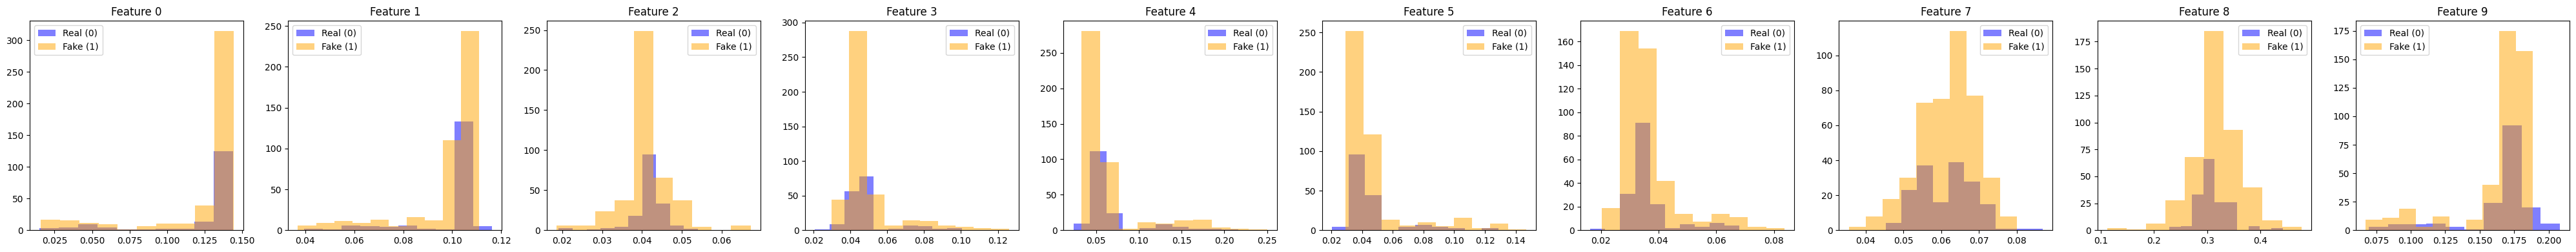

In [44]:
import matplotlib.pyplot as plt

num_features = 10  # Número de features que quieres visualizar (puedes cambiarlo)
fig, axes = plt.subplots(1, num_features, figsize=(4 * num_features, 4))

for i in range(num_features):
    axes[i].hist(X_train[y_train == 0][:, i], alpha=0.5, label='Real (0)', color='blue')
    axes[i].hist(X_train[y_train == 1][:, i], alpha=0.5, label='Fake (1)', color='orange')
    axes[i].set_title(f'Feature {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()